### Package

In [46]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split


from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

import time
from IPython.display import display

#### Preprocessing
   - device_id = 74DA388FF60A

In [47]:
device_id = ['74DA388FF60A']
month = ['January', 'February', 'March']  

for  i in range(3): #use three-month-data
    
    file_name="20170"+str(i+1)+"_Taiwan.csv"
    raw_data = pd.read_csv(file_name)# read csv from january to March
    
    raw_data = raw_data.drop([  # remove columns that won't use
            'PM10',
            'PM1',
            'Temperature',
            'Humidity',
            ' lat',
            ' lon'], axis = 1)
    
    grouped = raw_data.groupby( ["device_id"] )
    for name, group in grouped:
        if name in device_id: #select one sensor 
            print("Processing Month:"+month[i]+"_0"+str(i+1)+", device_id:"+name)
            group=group.drop(['device_id'], axis = 1)# remove device_id column
            filename = str(name) +"_2017_"+month[i]+"_PM2.5.csv"
            group.to_csv(filename) #save as csv file

Processing Month:January_01, device_id:74DA388FF60A
Processing Month:February_02, device_id:74DA388FF60A
Processing Month:March_03, device_id:74DA388FF60A


In [48]:
all_months = []
for  i in range(3): #use three-month-data
    print("Processing Month: "+month[i])
    PM25_tmp= pd.read_csv("74DA388FF60A_2017_"+month[i]+"_PM2.5.csv", index_col=0,parse_dates=[['Date', 'Time']]) #Parse Date和Time 欄位,變成Time Series data
    PM25_tmp = PM25_tmp.loc[:, ~PM25_tmp.columns.str.contains('^Unnamed')]# remove unamed column
    all_months.append(PM25_tmp)


PM25 = pd.concat(all_months)
display(PM25.head())
display(PM25.tail())

Processing Month: January
Processing Month: February
Processing Month: March


,PM2.5
Date_Time,
2017-01-01 08:00:00,31.0
2017-01-01 08:00:00,31.0
2017-01-01 08:00:00,31.0
2017-01-01 08:05:58,30.0
2017-01-01 08:05:58,30.0


,PM2.5
Date_Time,
2017-03-31 23:34:33,8.0
2017-03-31 23:40:28,8.0
2017-03-31 23:46:22,8.0
2017-03-31 23:52:16,9.0
2017-03-31 23:58:10,9.0


#### Data alignment 

In [49]:
PM25 = PM25.resample('15T').mean() #sample rate is 1 data / 15 minutes
PM25 = PM25.interpolate(method='linear')#linear interplolation 
display(PM25.head())

PM25.to_csv('PM2.5_preprocessed_dataset.csv')

,PM2.5
Date_Time,
2017-01-01 08:00:00,30.5
2017-01-01 08:15:00,23.0
2017-01-01 08:30:00,23.0
2017-01-01 08:45:00,21.5
2017-01-01 09:00:00,20.0


### Define the input and output (X and Y)

#### Input X

In [50]:
display(PM25.iloc[0:4]) #input: historical data
display(PM25.iloc[0:4].T) #number of features:4

,PM2.5
Date_Time,
2017-01-01 08:00:00,30.5
2017-01-01 08:15:00,23.0
2017-01-01 08:30:00,23.0
2017-01-01 08:45:00,21.5


Date_Time,2017-01-01 08:00:00,2017-01-01 08:15:00,2017-01-01 08:30:00,2017-01-01 08:45:00
PM2.5,30.5,23.0,23.0,21.5


#### Output Y

In [51]:
display(PM25.iloc[7]) #output: PM2.5 value after 1 hour

PM2.5    17.0
Name: 2017-01-01 09:45:00, dtype: float64

#### N-hour-data

In [52]:
print(PM25.shape)

(8608, 1)


In [53]:
for i in range(8601): #8608 rows(data points)  (approximately get 4 * 24 * 30 * 3 = 8640 data points)
    
    if i == 0 : #初始data,因為append函式要用兩組dataframe連接,所以要給定一個初始的dataframe
        result1 = PM25.iloc[i:i+4].append(PM25.iloc[i+7]) #historical data 和 PM2.5 value after 1 hour 透過append合併
        result1 = result1.T #將data透過.T轉置
        result1.columns = ['x1', 'x2', 'x3', 'x4', 'y'] #定義column names
    else :
#         result2 = pd.DataFrame({'' : []})
        result2 = PM25.iloc[i:i+4].append(PM25.iloc[i+7])
        result2 = result2.T
        result2.columns = ['x1', 'x2', 'x3', 'x4', 'y']
        result1=result1.append(result2) #將所有data透過append接成完整的training 和 testing data

display(result1.head()) 

result1.to_csv('PM2.5_input_and_output_dataset.csv')
        

,x1,x2,x3,x4,y
PM2.5,30.5,23.0,23.0,21.5,17.0
PM2.5,23.0,23.0,21.5,20.0,16.0
PM2.5,23.0,21.5,20.0,19.0,17.0
PM2.5,21.5,20.0,19.0,19.0,17.0
PM2.5,20.0,19.0,19.0,17.0,16.5


### 1. Try classification models to predict PM2.5 value:

#### a. Descritization(將原來Y的值除以10和20)

In [54]:
dataset = pd.read_csv("PM2.5_input_and_output_dataset.csv")#讀取 N-hour-data
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]#將unamed column去除

dataset['Descritization_10'] = dataset['y']/10 #Descritization with divided 10
dataset['Descritization_10'] = dataset['Descritization_10'].astype(int)#將Descritization後的結果取整數
dataset['Descritization_20'] = dataset['y']/20 #Descritization with divided 20
dataset['Descritization_20'] = dataset['Descritization_20'].astype(int)#將Descritization後的結果取整數

#### label definitions_1 (LABEL:0~9)

In [55]:
dataset = dataset[dataset.Descritization_10 < 10] 
dataset.Descritization_10.value_counts(ascending=False).to_frame().sort_index()#將label個別數量,以ascending方式顯示

,Descritization_10
0,621
1,1343
2,1700
3,1939
4,1786
5,861
6,225
7,65
8,43
9,12


#### label definitions_2

In [56]:
dataset = dataset[dataset.Descritization_20 < 5] 
dataset.Descritization_20.value_counts(ascending=True).to_frame().sort_index() 

,Descritization_20
0,1964
1,3639
2,2647
3,290
4,55


#### Randomly split the data to training data and testing data. (70% / 30%)

In [57]:
PM25_X = dataset.drop(['y'], axis = 1)#remove column  y 
PM25_X = PM25_X.values #turn dataframe into numpy array
PM25_Y_10 = dataset['Descritization_10'].values #turn dataframe into numpy array
PM25_Y_20 = dataset['Descritization_20'].values #turn dataframe into numpy array

#split dataset into training data:70%  and testing data:30%
train_X_label1, test_X_label1, train_y_label1, test_y_label1 = train_test_split(PM25_X, PM25_Y_10, test_size = 0.3)#label1
train_X_label2, test_X_label2, train_y_label2, test_y_label2 = train_test_split(PM25_X, PM25_Y_20, test_size = 0.3)#label2


#### b. Try following models (Original Input)
- i. K-Nearest-Neighbor
- ii. Naive Bayes
- iii. Random Forest
- iv. Support vector machine (SVC)

In [58]:
classifiers_label1= []
classifiers_label1_titles = []

classifiers_label2= []
classifiers_label2_titles = []

train_computation_time_label1=[]
train_computation_time_label2=[]

#### K-Nearest-Neighbor

In [59]:
K_Nearest_Neighbor1 = neighbors.KNeighborsClassifier(n_neighbors=10) #for Original Input with label1 0~9
K_Nearest_Neighbor2 = neighbors.KNeighborsClassifier(n_neighbors=5)  #for Original Input with label2 0~4

start_time = time.time()
classifier1_label1 = K_Nearest_Neighbor1.fit(train_X_label1,  train_y_label1)#Original Input with label1 0~9
train_computation_time_label1.append(time.time()-start_time)

start_time = time.time()
classifier1_label2 = K_Nearest_Neighbor2.fit(train_X_label2,  train_y_label2)#Original Input with label2 0~4
train_computation_time_label2.append(time.time()-start_time)


classifiers_label1.append(classifier1_label1)
classifiers_label1_titles.append('K_Nearest_Neighbor label1')

classifiers_label2.append(classifier1_label2)
classifiers_label2_titles.append('K_Nearest_Neighbor label2')

#### Naive Bayes 

In [60]:
Naive_Bayes1 = GaussianNB() #for Original Input with label1 0~9
Naive_Bayes2 = GaussianNB()  #for Original Input with label2 0~4


start_time = time.time()
classifier2_label1 = Naive_Bayes1.fit(train_X_label1,   train_y_label1)#Original Input with label1 0~9
train_computation_time_label1.append(time.time()-start_time)


start_time = time.time()
classifier2_label2 = Naive_Bayes2.fit(train_X_label2,   train_y_label2)#Original Input with label2 0~4
train_computation_time_label2.append(time.time()-start_time)



classifiers_label1.append(classifier2_label1)
classifiers_label1_titles.append('Naive_Bayes label1')

classifiers_label2.append(classifier2_label2)
classifiers_label2_titles.append('Naive_Bayes label2')

#### Random Forest 

In [61]:
Random_Forest1 = RandomForestClassifier(max_depth=5) #for Original Input with label1 0~9
Random_Forest2 = RandomForestClassifier(max_depth=5) #for Original Input with label2 0~4

start_time = time.time()
classifier3_label1 = Random_Forest1.fit(train_X_label1, train_y_label1)#Original Input with label1 0~9
train_computation_time_label1.append(time.time()-start_time)


start_time = time.time()
classifier3_label2 = Random_Forest2.fit(train_X_label2, train_y_label2)#Original Input with label2 0~4
train_computation_time_label2.append(time.time()-start_time)


classifiers_label1.append(classifier3_label1)
classifiers_label1_titles.append('Random_Forest label1')

classifiers_label2.append(classifier3_label2)
classifiers_label2_titles.append('Random_Forest label2')

#### Support vector machine(SVC)

In [62]:
Support_Vector_Machine_SVC1 = svm.SVC(C=2.0,kernel='rbf') #for Original Input with label1 0~9
Support_Vector_Machine_SVC2 = svm.SVC(C=2.0,kernel='rbf')#for Original Input with label2 0~4

start_time = time.time()
classifier4_label1 = Support_Vector_Machine_SVC1.fit(train_X_label1, train_y_label1)#Original Input with label1 0~9
train_computation_time_label1.append(time.time()-start_time)

start_time = time.time()
classifier4_label2 = Support_Vector_Machine_SVC2.fit(train_X_label2, train_y_label2)#Original Input with label2 0~4
train_computation_time_label2.append(time.time()-start_time)


classifiers_label1.append(classifier4_label1)
classifiers_label1_titles.append('Support_Vector_Machine label1')

classifiers_label2.append(classifier4_label2)
classifiers_label2_titles.append('Support_Vector_Machine label2')

#### c. Evaluation and Comprasion

- #### accuracy

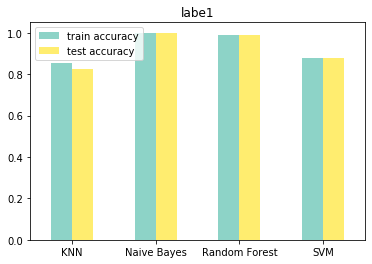

In [63]:

train_label1_accuracy=[]
test_label1_accuracy=[]
test_computation_time_label1=[]
index = ['KNN','Naive Bayes','Random Forest','SVM']

for i in range(len(classifiers_label1)):
    start_time = time.time()
    pred_train_y_label1 = classifiers_label1[i].predict(train_X_label1)
    pred_test_y_label1 = classifiers_label1[i].predict(test_X_label1)
    test_computation_time_label1.append(time.time()-start_time)

    train_label1_accuracy.append(accuracy_score( train_y_label1,  pred_train_y_label1 ))
    test_label1_accuracy.append(accuracy_score(test_y_label1, pred_test_y_label1))

df = pd.DataFrame({'train accuracy': train_label1_accuracy,
                    'test accuracy': test_label1_accuracy}, 
                  index=index)
ax = df.plot.bar(rot=0,colormap='Set3',title='labe1')




- #### confusion_matrix 

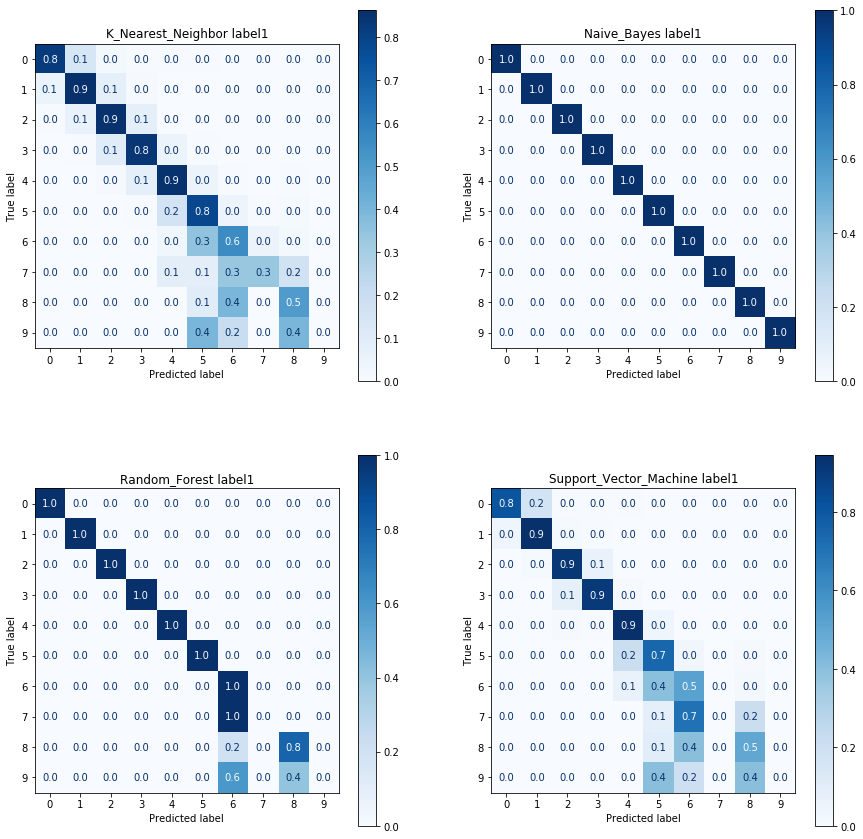

In [64]:

fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs_=[axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1]]

for i in range(len(classifiers_label1)):
    disp = plot_confusion_matrix(classifiers_label1[i], 
                                 test_X_label1,
                                 test_y_label1,
                                 cmap=plt.cm.Blues,
                                 values_format='.1f',
                                 normalize='true',
                                ax=axs_[i])
    disp.ax_.set_title(classifiers_label1_titles[i])


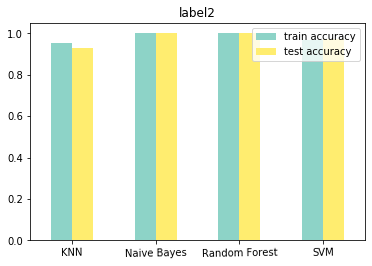

In [65]:

train_label2_accuracy=[]
test_label2_accuracy=[]
test_computation_time_label2=[]

for i in range(len(classifiers_label2)):
    start_time=time.time()
    pred_train_y_label2 = classifiers_label2[i].predict(train_X_label2)
    pred_test_y_label2 = classifiers_label2[i].predict(test_X_label2)
    test_computation_time_label2.append(time.time()-start_time)

    train_label2_accuracy.append(accuracy_score( train_y_label2,  pred_train_y_label2 ))
    test_label2_accuracy.append(accuracy_score(test_y_label2, pred_test_y_label2))

# index = classifiers_label1_titles
df = pd.DataFrame({'train accuracy': train_label2_accuracy,
                    'test accuracy': test_label2_accuracy}, 
                  index=index)
ax = df.plot.bar(title='label2',colormap='Set3',rot=True)

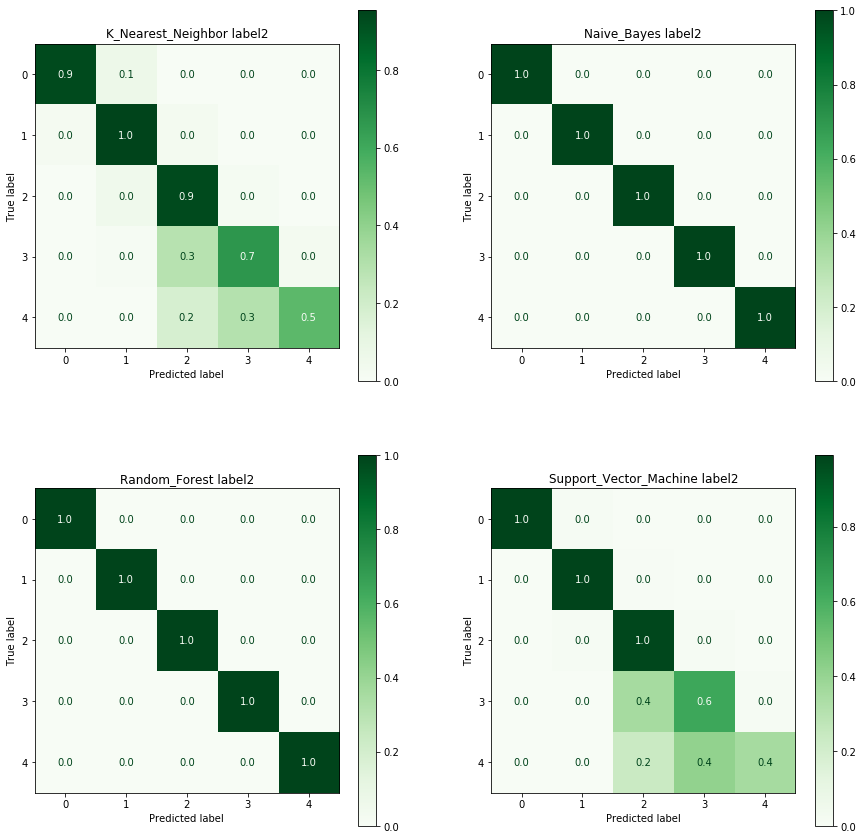

In [66]:

fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs_=[axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1]]

for i in range(len(classifiers_label1)):
    disp = plot_confusion_matrix(classifiers_label2[i], 
                                 test_X_label2, 
                                 test_y_label2,
                                 cmap=plt.cm.Greens,
                                 values_format='.1f',
                                 normalize='true',
                                ax=axs_[i])
    disp.ax_.set_title(classifiers_label2_titles[i])

##### training & testing computation time

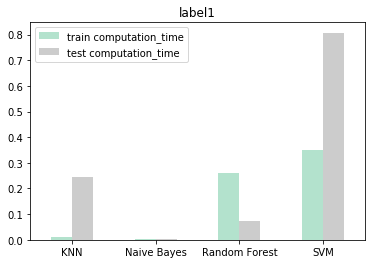

In [67]:
# index = classifiers_label1_titles
df = pd.DataFrame({'train computation_time': train_computation_time_label1,
                    'test computation_time': test_computation_time_label1}, 
                  index=index)
ax = df.plot.bar(rot=0,colormap='Pastel2',title='label1')

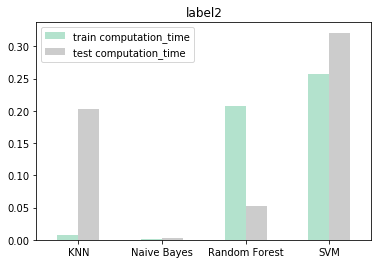

In [68]:
df = pd.DataFrame({'train computation_time': train_computation_time_label2,
                    'test computation_time': test_computation_time_label2}, 
                  index=index)
ax = df.plot.bar(rot=0,colormap='Pastel2',title='label2')

### Try regression models to predict PM2.5 value

#### Randomly split the data to training data and testing data. (70% / 30%)

In [130]:
PM25_Y = dataset['y'].values # turn dataframe into numpy array

#split dataset into training data:70% /  testing data:30%
train_X, test_X, train_y, test_y= train_test_split(PM25_X, PM25_Y, test_size = 0.3)

regression_model = []
regression_model_titles = ['Bayesian','Decision tree','Support vector machine']

train_computation_time=[]


# a. Try following models
- i. Bayesian Regression
- ii. Decision tree Regression
- iii. Support vector machine (SVR)

#### Bayesian Regression 

In [131]:
Bayesian_Regression= BayesianRidge()

start_time=time.time()
regression_model1 = Bayesian_Regression.fit(train_X, train_y)
train_computation_time.append(time.time()-start_time)

regression_model.append(regression_model1)

#### Decision tree Regression

In [132]:
Decision_Tree_Regressor = DecisionTreeRegressor(max_depth=5)#Original Input

start_time=time.time()
regression_model2 = Decision_Tree_Regressor.fit(train_X, train_y)
train_computation_time.append(time.time()-start_time)

regression_model.append(regression_model2)

#### Support vector machine (SVR)

In [133]:
Support_Vector_Machine_SVR = svm.SVR(C=2.0,kernel='rbf')

start_time=time.time()
regression_model3 = Support_Vector_Machine_SVR.fit(train_X, train_y)
train_computation_time.append(time.time()-start_time)


regression_model.append(regression_model3)

#### Evaluation and Comprasion

##### Mean squared error

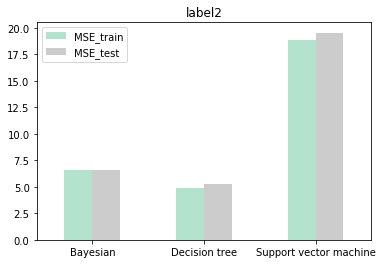

In [134]:
MSE_train=[]
MSE_test=[]
test_computation_time=[]

regression_train_df = pd.DataFrame( )
regression_train_df['Train True'] = train_y
regression_test_df = pd.DataFrame( )
regression_test_df['Test True'] = test_y


for i in range(len(regression_model)):
    
    start_time=time.time()
    train_y_pred = regression_model[i].predict(train_X)
    test_y_pred = regression_model[i].predict(test_X)
    test_computation_time.append(time.time() - start_time)

    regression_train_df[regression_model_titles[i]]=train_y_pred
    regression_test_df[regression_model_titles[i]]=test_y_pred


    MSE_train.append(mean_squared_error(train_y, train_y_pred))
    MSE_test.append(mean_squared_error(test_y, test_y_pred))

df = pd.DataFrame({'MSE_train': MSE_train,
                    'MSE_test':MSE_test}, 
                  index=regression_model_titles)
df.head()
ax = df.plot.bar(rot=0,colormap='Pastel2',title='label2')

##### training & testing computation time

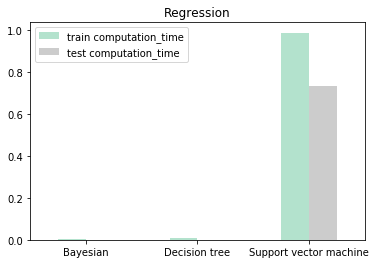

In [135]:

df = pd.DataFrame({'train computation_time': train_computation_time,
                    'test computation_time': test_computation_time}, 
                    index=regression_model_titles)
ax = df.plot.bar(rot=0,colormap='Pastel2',title='Regression')

##### Plot predict value & True value

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216098FA2C8>,
      dtype=object)

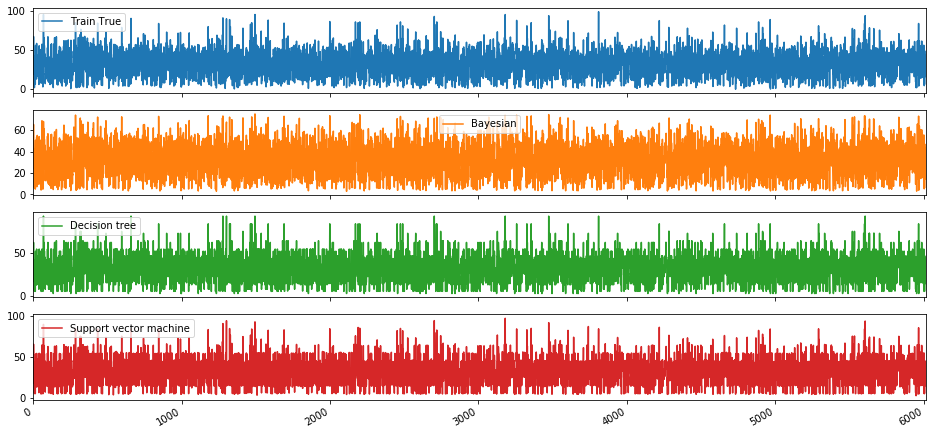

In [118]:
regression_train_df.plot(subplots =True,figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002161A2F21C8>,
      dtype=object)

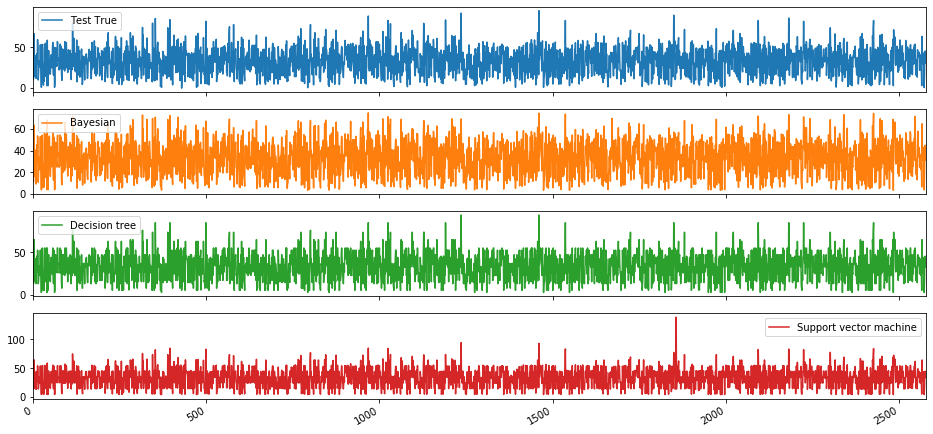

In [119]:
regression_test_df.plot(subplots =True,figsize=(16,8))